In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import arch 
import matplotlib.pyplot as plt
import random
import requests
from bs4 import BeautifulSoup
import warnings


In [2]:
###Define Parameters of the portfolio 

period="1y"  ###Data period. Used for computing returns and volatilities
Stocks= ["MSFT","META","KO","JPM","TSCO","JNJ"]##Portfolio Tickers
Value_Invested= 10000



In [3]:


SP500names = 'https://stockanalysis.com/list/sp-500-stocks/'
response = requests.get(SP500names)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')  ### response.content give you the code for the webpage
    ##The BeautifulSoup constructor takes the HTML content and parses it into a BeautifulSoup object. The second argument specifies the parser to use. 'html.parser' is a built-in parser in Python, but you can also use other parsers like lxml or html5lib
    
    # Find the table element
    table = soup.find('table')###Finds the first defined table
    
    # Read the table into a DataFrame
    SP500names = pd.read_html(str(table))[0]

else:
    print(f"Failed to retrieve webpage. Status code: {response.status_code}")


In [4]:
SP500tickers=list(SP500names["Symbol"])
SP500companies=list(SP500names["Company Name"])
S500name=pd.DataFrame({"Tickers":SP500tickers,"Companies":SP500companies})

In [5]:
def fetch_stock_data(ticker,time):
    try:
        stock = yf.Ticker(ticker)
        hist_High = stock.history(period=time)["High"]
        hist_Low = stock.history(period=time)["Low"]
        hist= pd.DataFrame({str(ticker):(hist_Low+hist_High)/2})
        return hist
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None
    

In [6]:
# Ignore all warnings
warnings.filterwarnings('ignore')
DataSP500=pd.DataFrame()
for i in SP500tickers: 
    DataSP500[str(i)]=fetch_stock_data(i,period)
DataSP500=DataSP500[::-1]
warnings.filterwarnings('ignore')


BRK.B: No data found, symbol may be delisted
BRK.B: No data found, symbol may be delisted
$AEP: possibly delisted; No price data found  (period=1y)
GEV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
GEV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)


$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)


SOLV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SOLV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']


In [7]:
from datetime import datetime, timedelta
#Today's date
today = datetime.today()

# Calculate yesterday's date
yesterday = today - timedelta(days=1)

DataSP500.index=pd.date_range(end=yesterday, periods=len(DataSP500),freq="B")

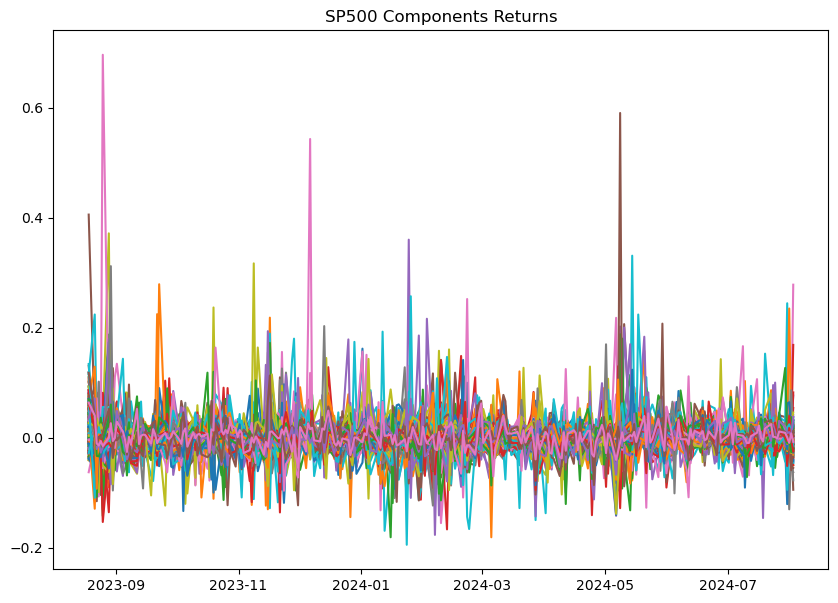

In [8]:
SP500Ret=DataSP500.pct_change().iloc[1:]

for i in DataSP500: 
    if sum(np.log(1+SP500Ret.replace(np.nan,0)[i]))==0: 
        SP500Ret=SP500Ret.drop(columns=[i])

plt.figure(figsize=(10, 7))
for column in SP500Ret.columns:
    plt.plot(SP500Ret[column], label=column)
# plt.legend(fontsize='small')
plt.title("SP500 Components Returns")
plt.show()

In [9]:
##Volatilities: 
YearlyVolSP500=pd.DataFrame()
for i in SP500Ret: 
    YearlyVolSP500[str(i)]=[np.std(SP500Ret[i])]
YearlyVolSP500=YearlyVolSP500.transpose()
YearlyVolSP500.columns=["1YVols"]

Company with max volatility over the last 1y:Super Micro Computer, Inc.


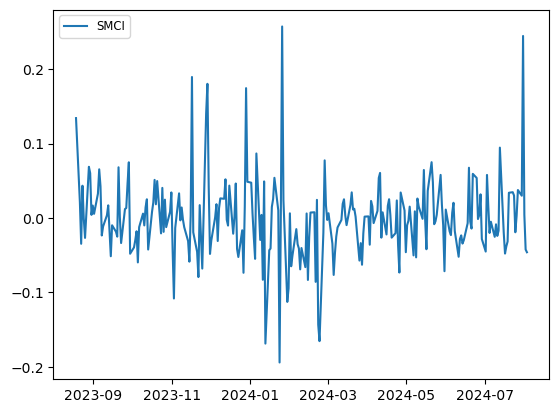

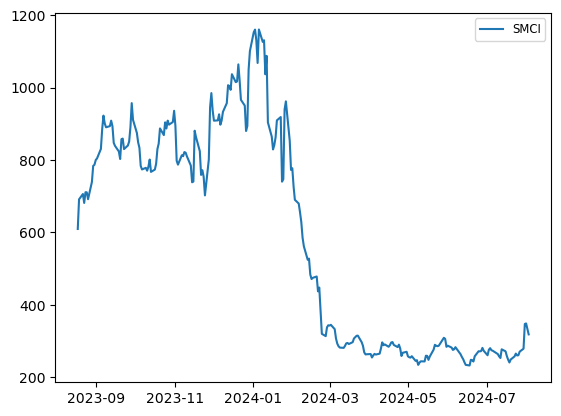

In [10]:
max(YearlyVolSP500["1YVols"])
MaxTicker=YearlyVolSP500.index[YearlyVolSP500['1YVols'] == max(YearlyVolSP500["1YVols"])].tolist()[0]

print("Company with max volatility over the last " + period+ ":" + S500name[S500name["Tickers"]==MaxTicker]["Companies"].tolist()[0])
plt.plot(SP500Ret[MaxTicker],label=MaxTicker)
plt.legend(fontsize='small')
plt.show()

plt.plot(DataSP500[MaxTicker],label=MaxTicker)
plt.legend(fontsize='small')
plt.show()



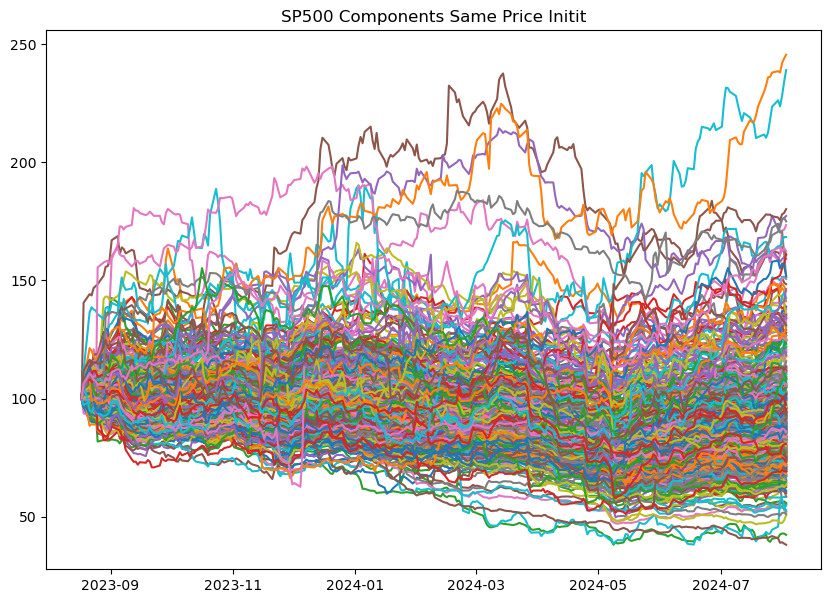

In [11]:
####Price Path over the last

SP500PricePath=pd.DataFrame()

for i in SP500Ret: 
    PricePath=[100]
    for j in range(0,len(SP500Ret[i])):
        PricePath.append(PricePath[j]*(1+SP500Ret[i].iloc[j]))
    SP500PricePath[i]=PricePath
SP500PricePath.index=DataSP500.index

plt.figure(figsize=(10, 7))
for column in SP500PricePath.columns:
    plt.plot(SP500PricePath[column], label=column)
# plt.legend(fontsize='small')
plt.title("SP500 Components Same Price Initit")
plt.show()

In [12]:
import cvxpy as cp


### Recursive Hyperparameter Method

ReturnsPort = SP500Ret[Stocks]
cov_matrix = SP500Ret[Stocks].cov()

weights = cp.Variable(len(Stocks))

# Define the objective function (portfolio variance)
portfolio_var = cp.quad_form(weights, cov_matrix)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0
]

# Define the optimization problem
problem = cp.Problem(cp.Minimize(portfolio_var), constraints)

# Solve the problem
problem.solve()

# Extract and print the optimal weights
min_variance_weights = weights.value
print("\nOptimal Weights for Minimum Variance Portfolio:")
Weights = pd.DataFrame(min_variance_weights).transpose()
Weights.columns = Stocks
Weights.index = ["Weights"]
print(Weights)

# Calculate and print the minimum variance
min_variance = portfolio_var.value
print(f"\nMinimum Variance: {min_variance:.6f}")
print(f"\nMinimum Volatility: {np.sqrt(min_variance):.6f}")


Optimal Weights for Minimum Variance Portfolio:
             MSFT      META        KO      JPM      TSCO       JNJ
Weights  0.235704  0.014379  0.423205  0.08376  0.045465  0.197487

Minimum Variance: 0.000022

Minimum Volatility: 0.004643


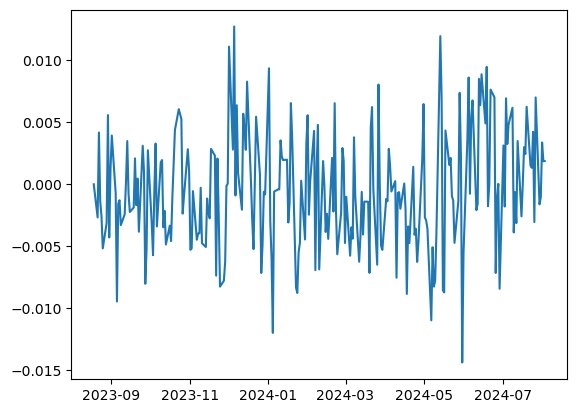

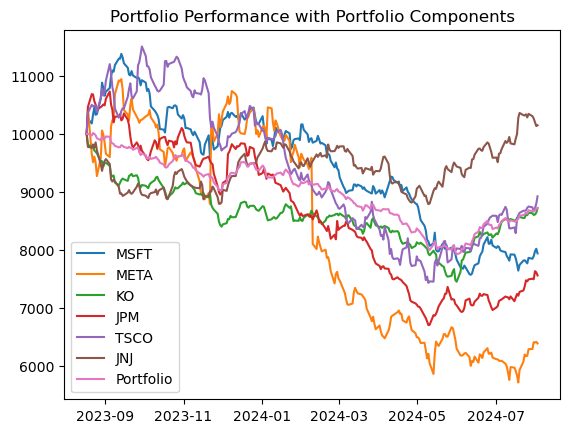

The yearly return on the portfolio is:-12.78%


In [13]:
ReturnsOptimal=pd.DataFrame(ReturnsPort[i]*float(Weights[i]) for i in Weights)
ReturnsOptimal_Portfolio=ReturnsOptimal.sum()
axx=plt.plot(ReturnsOptimal_Portfolio)
plt.show()

PortfolioPerformance=[Value_Invested]
for i in range(0,len(ReturnsOptimal_Portfolio)): 
    PortfolioPerformance.append(PortfolioPerformance[i]*(1+ReturnsOptimal_Portfolio[i]))

PortfolioPerformance=pd.DataFrame(PortfolioPerformance)
    
PortfolioPerformance.index=SP500PricePath.index
PortfolioPerformance.columns=["Portfolio"]

SP500PricePath_Portfolio_D=pd.DataFrame()

for i in Stocks: 
    SP500PricePath_Portfolio=[Value_Invested]
    for j in range(0,len(SP500Ret[i])):
        SP500PricePath_Portfolio.append(SP500PricePath_Portfolio[j]*(1+SP500Ret[i].iloc[j]))
    SP500PricePath_Portfolio_D[i]=SP500PricePath_Portfolio
SP500PricePath_Portfolio_D.index=PortfolioPerformance.index


PortfolioPerformance=pd.concat([SP500PricePath_Portfolio_D,PortfolioPerformance],axis=1)

for column in PortfolioPerformance.columns:
    plt.plot(PortfolioPerformance[column], label=column)
plt.title("Portfolio Performance with Portfolio Components")
plt.legend()
plt.show()

Yearly_Return=np.exp(sum(np.log(1+ReturnsOptimal_Portfolio)))-1

print(f"The yearly return on the portfolio is:{round(Yearly_Return*100,2)}%")